<a href="https://colab.research.google.com/github/hirotaka-i/sandbox/blob/master/JPPMI_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PK Analysis

# Mount gdrive

In [22]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [23]:
# activate R magic
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Create dataset

In [24]:
import pandas as pd
import numpy as np
import os
os.chdir('/content/drive/My Drive/2020/NCNP2/rawData/ECB_20191209091348')


# create dataset
## define the deriving columns
variables = {
    'sex': ('dm', '性別'),
    'age_at_baseline': ('dm', '年齢(歳)'),
    'asian':('dm', '人種-アジア人である'),
    'mibg_hm_ratio':('pr6', '結果（各医療機関の放射線科医の判断）-H/M比'),
    'osit_j': ('qs01', 'スコア'),
    'updrs1':('qs02', 'Part I 合計'),
    'updrs2':('qs02', 'Part II 合計'),
    'updrs3':('qs02', 'Part III 合計'), 
    'hy':('qs02', 'Hoehn and Yahr 重症度'),
    'seadl':('qs03', '評価者、患者等の総合評価（責任医師/分担医師、患者、他の情報提供者）(%)'),
    'diagnosis':('qs04', '現在、最もあてはまりそうな臨床診断'),
    'moca_j':('qs06', '合計得点(/30)'),
    'ess':('qs07', '合計得点'),
    'rbdsq':('qs08', '合計得点'),
    'gds15':('qs09', '合計得点'),
    'stai_y_p':('qs10', '合計（Y-2）-P項目'),
    'stai_y_a':('qs10', '合計（Y-2）-A項目'),
    'quip_s':('qs11', '合計得点'),
    'scopa_01':('qs12', '1.'),
    'scopa_02':('qs12', '2.'),
    'scopa_03':('qs12', '3.'),
    'scopa_04':('qs12', '4.'),
    'scopa_05':('qs12', '5.'),
    'scopa_06':('qs12', '6.'),
    'scopa_07':('qs12', '7.'),
    'scopa_08':('qs12', '8.'),
    'scopa_09':('qs12', '9.'),
    'scopa_10':('qs12', '10.'),
    'scopa_11':('qs12', '11.'),
    'scopa_12':('qs12', '12.'),
    'scopa_13':('qs12', '13.'),
    'scopa_14':('qs12', '14.'),
    'scopa_15':('qs12', '15.'),
    'scopa_16':('qs12', '16.'),
    'scopa_17':('qs12', '17.'),
    'scopa_18':('qs12', '18.'),
    'scopa_19':('qs12', '19.'),
    'scopa_20':('qs12', '20.'),
    'scopa_21':('qs12', '21.'),
    'scopa_22':('qs12', '22.'),
    'scopa_23':('qs12', '23.'),
    'scopa_24':('qs12', '24.'),
    'scopa_25':('qs12', '25.'),
    'educ_years':('sc', '被験者の教育（教育年数）(年)'),
    'fam_mom':('sqapmh', '母親（Biological Mother）-PDもしくはパーキンソニズムの人数'),
    'fam_dad':('sqapmh', '父親（Biological Father）-PDもしくはパーキンソニズムの人数'),
    'fam_sibl':('sqapmh', '兄弟姉妹-PDもしくはパーキンソニズムの人数'),
    'weight':('vs', '体重(kg)'),
    'height':('vs', '身長(cm)'),
    'hr_standing':('vs', '心拍数（立位）(回/分)'),
    'hr_supine':('vs', '心拍数（仰臥位）(回/分)'),
    'sbp_standing':('vs', '血圧（立位）-収縮期(mmHg)'),
    'dbp_standing':('vs', '血圧（立位）-拡張期(mmHg)'),
    'sbp_supine':('vs', '血圧（仰臥位）-収縮期(mmHg)'),
    'dbp_supine':('vs', '血圧（仰臥位）-拡張期(mmHg)'),
    }

# get the variables
dfs = {}
for v, (d, c) in variables.items():
  t = pd.read_csv(f'{d}.csv', encoding="cp932", index_col = ['登録番号','報告書', 'ビジット番号'])
  dfs[f'{v}'] = t[c]
df = pd.concat(dfs, axis = 1).reset_index()

# translate in english
df = df.rename(columns={'登録番号':'id', '報告書':'month', 'ビジット番号':'visit_id'})
df['month'] = df['month'].map({
    'VISIT01（6か月±30日）':6, 
    'VISIT02（12か月±30日）':12, 
    'VISIT03（18か月±30日）':18,
    'VISIT04（24か月±30日）':24, 
    'VISIT05（30か月±30日）':30, 
    'VISIT06（36か月±30日）':36,
    'VISIT07（42か月±30日）':42, 
    'VISIT08（48か月±30日）':48, 
    'VISIT09（54か月±30日）':54,
    'スクリーニング':-1, 
    'ベースライン':0, 
    '研究の途中中止':999
})
df = df.sort_values(['id', 'month'])


# save the dataset
df.to_csv('../ECB_20191209091348_derived.csv', index=False)

# Clustering analysis at baseline

## Create an table1 dataset

In [25]:
!pip install tableone

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from tableone import TableOne
os.chdir('/content/drive/My Drive/2020/NCNP2')


# Zscore for the baseline
d_z = pd.read_excel('rawData/SBR_screening.xlsx', nrows=109)
d_z = d_z.rename(columns = {'登録番号':'id', 'Z-score Ave':'dat_sbrz'})
d_z = d_z[['id', 'dat_sbrz']].copy()

# from case report form and fill values
d = pd.read_csv('rawData/ECB_20191209091348_derived.csv').sort_values(['id', 'month'])
d = d.groupby(['id'], as_index=False).fillna(method='ffill')

## create new variables
d['female'] = d.sex -1
d['delta_sbp'] = d.sbp_standing - d.sbp_supine
d['delta_dbp'] = d.dbp_standing - d.dbp_supine
d['oh_20_10'] = ((d.delta_sbp < - 20) | (d.delta_dbp < - 10))*1
d['oh_30_15'] = ((d.delta_sbp < - 30) | (d.delta_dbp < - 15))*1
d['scopa_aut'] = d[['scopa_01','scopa_02','scopa_03','scopa_04','scopa_05',
                     'scopa_06','scopa_07','scopa_08','scopa_09','scopa_10',
                     'scopa_11','scopa_12','scopa_13','scopa_14','scopa_15',
                     'scopa_16','scopa_17','scopa_18','scopa_19','scopa_20',
                     'scopa_21','scopa_22','scopa_23','scopa_24','scopa_25']].sum(axis=1, min_count=1)
d['family_history'] = (d[['fam_mom', 'fam_dad', 'fam_sibl']].sum(axis=1, min_count=1)>0)*1
d['bmi'] = d.weight/((d.height/100)**2)


## base line covariates.(relace NA with SC value and keep)
d_bl = d[d.month<=0].copy()
d_bl = d_bl.groupby(['id'], as_index=False).fillna(method='ffill')
d_bl = d_bl.drop_duplicates(subset=['id'], keep='last').copy()

# last diagnosis
d_dx = d[['id', 'diagnosis']].copy()
d_dx = d_dx.groupby(['id'], as_index=False).fillna(method='ffill')
d_dx = d_dx.drop_duplicates(subset = ['id'], keep='last')
d_dx = d_dx.rename(columns={'diagnosis':'last_dx'})


# combine data
d_bl_dx = pd.merge(d_bl, d_dx, on = 'id')
d_all = pd.merge(d_bl_dx, d_z, on='id').set_index('id')


# get the variables for table 1
variables = [
    'female',
    'age_at_baseline',
    'asian',
    'family_history',
    'diagnosis',
    'last_dx',
    'bmi',
    'educ_years',
    'mibg_hm_ratio',
    'dat_sbrz',
    'updrs1',
    'updrs2',
    'updrs3',
    'seadl',
    'moca_j',
    'scopa_aut',
    'ess',
    'rbdsq',
    'gds15',
    'stai_y_p',
    'stai_y_a',
    'quip_s',
    'osit_j',
    'hy',
    'oh_20_10',
    'oh_30_15']

df = d_all[variables].copy()
df.to_csv('df.csv', index_label='id')

# Create table 1
cat_vars = ['female', 'asian', 'family_history', 'hy', 
            'oh_20_10', 'oh_30_15', 'diagnosis', 'last_dx']
nnm_vars = ['ositJ', 'seadl', 'quip_s']
decimals = {'dat_sbrz':2, 'mibg_hm_ratio':2, 'age_at_baseline':1, 'ositJ':0,
            'updrs1':1, 'updrs2':1, 'updrs3':1,
            'seadl':0, 'quip_s':0}
mytable = TableOne(df, 
                   columns= variables,
                   categorical=cat_vars, 
                   nonnormal=nnm_vars, 
                  #  groupby='cluster', 
                   label_suffix=True, decimals=decimals)
mytable.to_csv('Table1_v1.csv')
mytable

Missing        Overall
n                                                  109
female, n (%)              0.0        0      30 (27.5)
                           1.0               79 (72.5)
age_at_baseline, mean (SD)            0     70.9 (5.5)
asian, n (%)               0.0        0        2 (1.8)
                           1.0              107 (98.2)
family_history, n (%)      0          0     103 (94.5)
                           1                   6 (5.5)
diagnosis, n (%)           1.0        0        1 (0.9)
                           17.0              67 (61.5)
                           19.0              28 (25.7)
                           20.0               10 (9.2)
                           21.0                1 (0.9)
                           7.0                 2 (1.8)
last_dx, n (%)             1.0        0        5 (4.6)
                           17.0              36 (33.0)
                           19.0              48 (44.0)
                           20.0              15 (13.8)
                           21.0                2 (1.8)
                           5.0                 3 (2.8)
bmi, mean (SD)                        1     22.9 (2.6)
educ_years, mean (SD)                 0     13.9 (2.4)
mibg_hm_ratio, mean (SD)              1    1.39 (0.36)
dat_sbrz, mean (SD)                   0   -1.16 (1.09)
updrs1, mean (SD)                     0      4.4 (3.1)
updrs2, mean (SD)                     0      1.0 (1.9)
updrs3, mean (SD)                     0      2.8 (4.3)
seadl, median [Q1,Q3]                 0  100 [100,100]
moca_j, mean (SD)                     0     24.6 (3.1)
scopa_aut, mean (SD)                  0     12.9 (5.3)
ess, mean (SD)                        0      6.0 (3.6)
rbdsq, mean (SD)                      2      7.4 (3.0)
gds15, mean (SD)                      0      2.5 (2.3)
stai_y_p, mean (SD)                   0     16.0 (4.1)
stai_y_a, mean (SD)                   0     21.1 (5.9)
quip_s, median [Q1,Q3]                0        0 [0,0]
osit_j, mean (SD)                     0      4.4 (2.7)
hy, n (%)                  0.0        0      99 (90.8)
                           1.0                 5 (4.6)
                           2.0                 4 (3.7)
                           3.0                 1 (0.9)
oh_20_10, n (%)            0          0      66 (60.6)
                           1                 43 (39.4)
oh_30_15, n (%)            0          0      90 (82.6)
                           1                 19 (17.4)
[1] Hartigan's Dip Test reports possible
                                  multimodal distributions for: educ_years, updrs1, updrs2, updrs3, moca_j, scopa_aut, ess, rbdsq, gds15, stai_y_p, quip_s, osit_j.
[2] Normality test reports non-normal
                                  distributions for: mibg_hm_ratio, updrs1, updrs2, updrs3, seadl, quip_s.
[3] Tukey test indicates far outliers
                                  in: mibg_hm_ratio, updrs2, updrs3, seadl, quip_s.

    1   パーキンソン病
    16  脳血管性パーキンソニズム
    17  パーキンソン病でも他の神経疾患でもない
    19  運動症状出現前の前駆期パーキンソン病（最低一つの非運動症状があり、運動症状はない）
    20  運動症状のある前駆期パーキンソン病（PDの診断にあう運動症状が最低一つある）
    21  その他の神経疾患
    5   Lewy小体型認知症
    7   本態性振戦
    2   アルツハイマー病

In [27]:
variables_for_analysis = [
    'female',
    'age_at_baseline',
    # 'asian',
    # 'family_history',
    # 'diagnosis',
    # 'last_dx',
    # 'bmi',
    # 'educ_years',
    'mibg_hm_ratio',
    'dat_sbrz',
    'updrs1',
    'updrs2',
    'updrs3',
    'seadl',
    'moca_j',
    'scopa_aut',
    # 'ess',
    # 'rbdsq',
    'gds15',
    'stai_y_p',
    'stai_y_a',
    'quip_s',
    'osit_j',
    'hy',
    'oh_20_10',
    'oh_30_15']

df_analysis = df[variables_for_analysis].dropna()
df_analysis.to_csv('df_analysis.csv', index_label='id')
df_analysis.shape

(108, 18)

## Clustering analysis 1 (PCA)

pca_shape (108, 5)


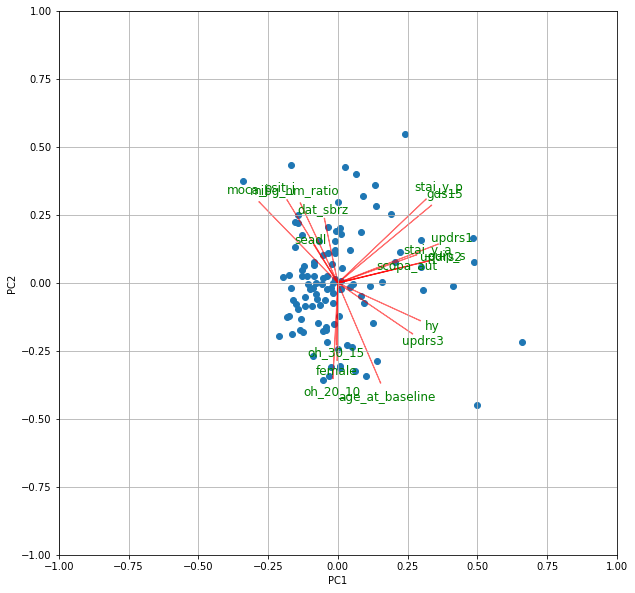

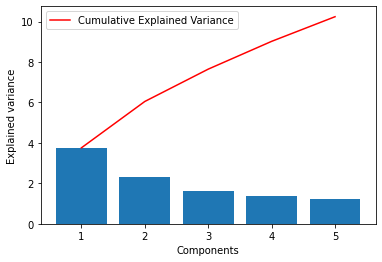

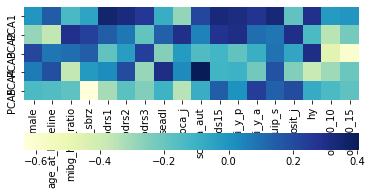

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


df = pd.read_csv('df_analysis.csv', index_col='id')

scaler = StandardScaler()
scaler.fit(df)
X = scaler.transform(df)
pcamodel = PCA(n_components=5)
pca = pcamodel.fit_transform(X)
print('pca_shape', pca.shape)

# for loading plot
def myplot(score, coeff, labels=None, pc_axis=[0,1]):
    xs = score[:,pc_axis[0]]
    ys = score[:,pc_axis[1]]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    # plt.scatter(xs * scalex,ys * scaley, c = y)
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pc_axis[0]], coeff[i,pc_axis[1]],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center', fontsize=12)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pc_axis[0]+1))
    plt.ylabel("PC{}".format(pc_axis[1]+1))
    plt.grid()

plt.figure(figsize=(10,10))
myplot(pca, np.transpose(pcamodel.components_), labels=df.columns,
       pc_axis=[0,1])  ############# can change this to [0,2] (PC1, PC3)for example
plt.show()

plt.bar(range(1,len(pcamodel.explained_variance_ )+1),pcamodel.explained_variance_)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pcamodel.explained_variance_ )+1),
         np.cumsum(pcamodel.explained_variance_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')
plt.show()

ax = sns.heatmap(pcamodel.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pcamodel.n_components_+1)],
                 xticklabels=list(df.columns),
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")
plt.show()

## Various algorithm for clustering

Automatically created module for IPython interactive environment


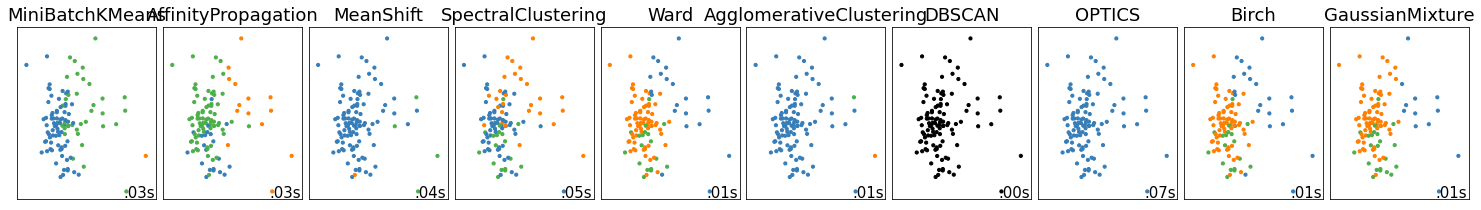

In [ ]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

#########################################################
df = pd.read_csv('df_analysis.csv', index_col='id')

#########################################################


np.random.seed(0)
no_structure = df, None


# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 2.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [(no_structure, {})]


dy = pd.DataFrame(index=df.index)

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        dy[name] = y_pred
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(pca[:, 0], pca[:, 1], s=10, color=colors[y_pred])
        plt.xlim(-5, 9)
        plt.ylim(-4, 5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

In [ ]:
# !pip install tableone
# from tableone import TableOne

In [ ]:
df = pd.read_csv('df.csv', index_col='id')
df_clustered = df.join(dy)
clustering_algorithms_name = 'Ward' ### can change the algorithm
mytable = TableOne(df_clustered, 
                   columns= variables, 
                   categorical=cat_vars, 
                   nonnormal=nnm_vars, 
                   groupby=clustering_algorithms_name, 
                   label_suffix=True, decimals=decimals)
df_clustered.to_csv('df_clustered.csv', index_label='id')
mytable.to_csv(f'Table2_{clustering_algorithms_name}.csv')
mytable

Grouped by Ward                                                            
                                        Missing        Overall            0.0            1.0            2.0
n                                                          109             21             69             18
female, n (%)              0.0                0      30 (27.5)       9 (42.9)      14 (20.3)       6 (33.3)
                           1.0                       79 (72.5)      12 (57.1)      55 (79.7)      12 (66.7)
age_at_baseline, mean (SD)                    0     70.9 (5.5)     69.9 (6.6)     70.8 (5.3)     72.2 (4.8)
asian, n (%)               0.0                0        2 (1.8)                       2 (2.9)               
                           1.0                      107 (98.2)     21 (100.0)      67 (97.1)     18 (100.0)
family_history, n (%)      0                  0     103 (94.5)      20 (95.2)      64 (92.8)     18 (100.0)
                           1                           6 (5.5)        1 (4.8)        5 (7.2)               
diagnosis, n (%)           1.0                0        1 (0.9)        1 (4.8)                              
                           17.0                      67 (61.5)      10 (47.6)      47 (68.1)      10 (55.6)
                           19.0                      28 (25.7)       7 (33.3)      16 (23.2)       4 (22.2)
                           20.0                       10 (9.2)        2 (9.5)        4 (5.8)       4 (22.2)
                           21.0                        1 (0.9)        1 (4.8)                              
                           7.0                         2 (1.8)                       2 (2.9)               
last_dx, n (%)             1.0                0        5 (4.6)        2 (9.5)        2 (2.9)        1 (5.6)
                           17.0                      36 (33.0)       5 (23.8)      26 (37.7)       5 (27.8)
                           19.0                      48 (44.0)       8 (38.1)      32 (46.4)       7 (38.9)
                           20.0                      15 (13.8)       4 (19.0)       7 (10.1)       4 (22.2)
                           21.0                        2 (1.8)        1 (4.8)        1 (1.4)               
                           5.0                         3 (2.8)        1 (4.8)        1 (1.4)        1 (5.6)
bmi, mean (SD)                                1     22.9 (2.6)     23.5 (3.1)     22.7 (2.6)     22.8 (2.1)
educ_years, mean (SD)                         0     13.9 (2.4)     12.1 (2.7)     14.3 (2.1)     14.3 (2.4)
mibg_hm_ratio, mean (SD)                      1    1.39 (0.36)    1.35 (0.32)    1.41 (0.40)    1.34 (0.17)
dat_sbrz, mean (SD)                           0   -1.16 (1.09)   -1.09 (1.11)   -1.10 (1.12)   -1.46 (0.97)
updrs1, mean (SD)                             0      4.4 (3.1)      8.1 (3.8)      3.3 (2.0)      4.1 (2.2)
updrs2, mean (SD)                             0      1.0 (1.9)      2.7 (3.0)      0.6 (1.3)      0.4 (1.2)
updrs3, mean (SD)                             0      2.8 (4.3)      5.7 (7.4)      2.0 (2.7)      2.3 (3.4)
seadl, median [Q1,Q3]                         0  100 [100,100]  100 [100,100]  100 [100,100]  100 [100,100]
moca_j, mean (SD)                             0     24.6 (3.1)     23.4 (4.2)     25.1 (2.8)     24.4 (2.2)
scopa_aut, mean (SD)                          0     12.9 (5.3)     15.0 (6.0)     12.0 (5.0)     13.4 (4.5)
ess, mean (SD)                                0      6.0 (3.6)      8.1 (3.5)      5.4 (3.5)      6.1 (3.2)
rbdsq, mean (SD)                              2      7.4 (3.0)      7.6 (3.2)      7.2 (3.1)      7.6 (2.5)
gds15, mean (SD)                              0      2.5 (2.3)      5.5 (2.0)      1.6 (1.4)      2.2 (1.9)
stai_y_p, mean (SD)                           0     16.0 (4.1)     20.5 (4.4)     14.7 (3.2)     15.8 (3.5)
stai_y_a, mean (SD)                           0     21.1 (5.9)     27.0 (4.7)     19.7 (5.1)     19.6 (5.7)
quip_s, median [Q1,Q3]              

In [ ]:
# dy.head()

# Regression Analyses (R)

In [34]:
import os
os.chdir('/content/drive/My Drive/2020/NCNP2')

In [35]:
%%R
library(tidyverse)
d = read.csv('df_clustered.csv') %>%
  mutate(rbd = (rbdsq>5)*1)
head(d)

t = names(d)
outcomes_cont = t[10:25]
outcomes_binom = t[c(26,27,38)]
outcomes = c(outcomes_cont, outcomes_binom)
predictors = c('dat_sbrz', 'mibg_hm_ratio')
res = data.frame(outcome = rep(outcomes, 2), 
                 predictor = rep(predictors, length(outcomes)),
                 beta=NA, se=NA, tval=NA, pval=NA, model=NA)
for(outcome in outcomes){
    for(predictor in predictors){
      # model = paste0(outcome, '~ female*age_at_baseline + ', predictor)
      model = paste0(outcome, '~ female*age_at_baseline + I(age_at_baseline^2) + ', predictor)
      if(outcome==predictor){next}

      if(outcome %in% outcomes_binom){
          ml = glm(as.formula(model), data=d, family=binomial()) %>% summary
      }else{
          ml = glm(as.formula(model), data=d) %>% summary
      }
      res[(res$outcome==outcome)&(res$predictor==predictor), 3:6] = coef(ml)[predictor,]
      res[(res$outcome==outcome)&(res$predictor==predictor), 7] = model
    }
}
write.csv(res, 'regression.csv',  row.names=FALSE)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.2     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [38]:
%%R
d = d %>% filter(moca_j>20)
outcomes = c(outcomes_cont, outcomes_binom)
predictors = c('dat_sbrz', 'mibg_hm_ratio')
res = data.frame(outcome = rep(outcomes, 2), 
                 predictor = rep(predictors, length(outcomes)),
                 beta=NA, se=NA, tval=NA, pval=NA, model=NA)
for(outcome in outcomes){
    for(predictor in predictors){
      # model = paste0(outcome, '~ female*age_at_baseline + ', predictor)
      model = paste0(outcome, '~ female*age_at_baseline + I(age_at_baseline^2) + ', predictor)
      if(outcome==predictor){next}

      if(outcome %in% outcomes_binom){
          ml = glm(as.formula(model), data=d, family=binomial()) %>% summary
      }else{
          ml = glm(as.formula(model), data=d) %>% summary
      }
      res[(res$outcome==outcome)&(res$predictor==predictor), 3:6] = coef(ml)[predictor,]
      res[(res$outcome==outcome)&(res$predictor==predictor), 7] = model
    }
}
write.csv(res, 'regression.csv',  row.names=FALSE)

In [40]:
%%R
res %>% arrange(pval)

         outcome     predictor          beta         se         tval       pval
1         moca_j      dat_sbrz  0.6538078895 0.21740198  3.007368562 0.00340684
2            rbd mibg_hm_ratio  3.6627354568 1.50117597  2.439910794 0.01469089
3         updrs1      dat_sbrz  0.6542482326 0.28253887  2.315604373 0.02282753
4      scopa_aut mibg_hm_ratio -2.6455619141 1.39287850 -1.899348657 0.06072147
5         moca_j mibg_hm_ratio  1.2389759096 0.67413719  1.837869112 0.06938090
6             hy mibg_hm_ratio  0.1663967472 0.10027973  1.659325779 0.10053109
7         quip_s mibg_hm_ratio -0.2441560022 0.14766575 -1.653436961 0.10172612
8            ess mibg_hm_ratio -1.7195773531 1.04657608 -1.643050499 0.10386186
9         updrs1 mibg_hm_ratio -1.3917586316 0.86787404 -1.603641278 0.11229696
10         rbdsq mibg_hm_ratio  1.2577661349 0.80655074  1.559438330 0.12248194
11         rbdsq      dat_sbrz  0.4167605848 0.27070177  1.539556177 0.12721658
12      dat_sbrz mibg_hm_ratio  0.460707